# Simple regression

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel, cv_adaptation, one_model_inference, simple_cv_adaptation
from pcv.plots import plot_model_results, plot_fold_results, plot_rhats
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt
import arviz as az

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

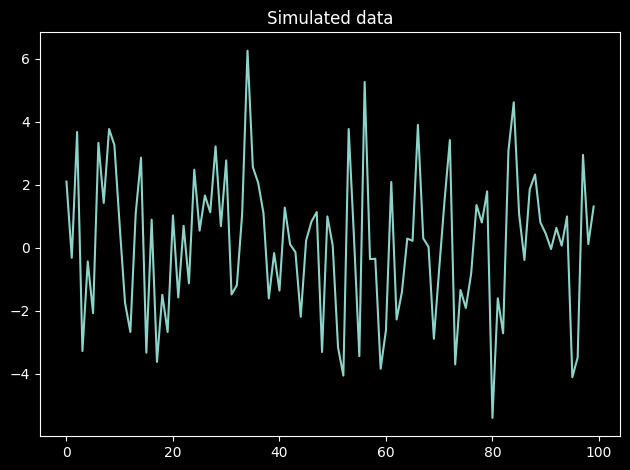

In [3]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.9]),
    sigsq0 = jnp.array(2.0))

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [4]:
K = 10
model = reg.get_model(y, X, K=K)

First, run model diagnostics.

In [5]:
idata, state = one_model_inference(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    model_id=0,
    num_chains=32,
    num_samples=10_000,
    warmup_iter=10_000,
    prior_only=False
)

In [6]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.880,0.129,0.636,1.124,0.001,0.000,50748.0,80010.0,1.0
beta[1],0.970,0.123,0.738,1.203,0.000,0.000,65881.0,102761.0,1.0
beta[2],1.005,0.110,0.801,1.215,0.000,0.000,70602.0,108173.0,1.0
beta[3],0.887,0.122,0.658,1.118,0.001,0.000,55866.0,88128.0,1.0
sigsq,1.498,0.216,1.116,1.910,0.001,0.001,64927.0,95603.0,1.0


In [7]:
print(f"Saw {state.divergences.sum()} divergences")

Saw 0.0 divergences


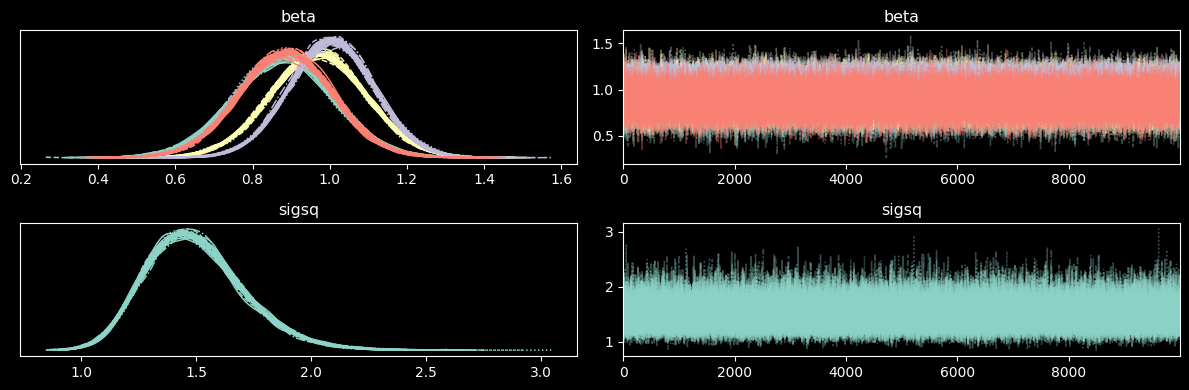

In [8]:
axes = az.plot_trace(idata)
plt.tight_layout()

## Cross-Validation


In [9]:
warmup_results = simple_cv_adaptation(
    prng_key=jax.random.PRNGKey(42),
    model=model,
    warmup_model_id=0,
    num_chains=4,
    adaptation_iter=1_000,
    burnin_iter=500,
    batch_size=100,
)

MEADS warmup for 2 model(s) (8 chains)...
Meads warmup done in 3.88 seconds. 
Step size: 0.1473 Alpha: 0.1894 Delta: 0.0947
Approximated 20 modes in 0 min 0.7 sec
Burn-in for 80 chains run took 0 min 4.9 sec


In [10]:
results = run_cv_sel(
       prng_key=jax.random.PRNGKey(0),
       model=model,
       stoprule=make_positive_negative_rule(num_folds=model.num_folds, level=0.95),
       warmup_results=warmup_results,
       batch_size=100,
       max_batches=50,
       ignore_stoprule=True,
       prior_only=False
)

Starting cross-validation with 80 parallel GHMC chains...
   0.  Model A: -184.23 ±7.59 ess 19807, Model B: -203.46 ±3.39 ess 20273
       Diff: 19.23 ±7.14, Rhat < 1.0386  stop
       Triggered stoprule after 1 batches in 4 seconds
  10.  Model A: -168.70 ±7.41 ess 55950, Model B: -189.06 ±3.08 ess 54846
       Diff: 20.37 ±7.01, Rhat < 1.0710  stop
  20.  Model A: -166.83 ±7.20 ess 90467, Model B: -187.30 ±3.08 ess 86239
       Diff: 20.47 ±6.66, Rhat < 1.0471  stop
  30.  Model A: -166.16 ±7.11 ess 123140, Model B: -186.77 ±3.08 ess 116967
       Diff: 20.61 ±6.56, Rhat < 1.0338  stop
  40.  Model A: -165.74 ±7.05 ess 155393, Model B: -186.46 ±3.04 ess 147319
       Diff: 20.72 ±6.51, Rhat < 1.0356  stop
  49.  Model A: -165.53 ±6.97 ess 185016, Model B: -186.30 ±3.02 ess 173976
       Diff: 20.77 ±6.46, Rhat < 1.0253  stop
Drew 400000 samples in 1 min 37 sec (4112 per sec)


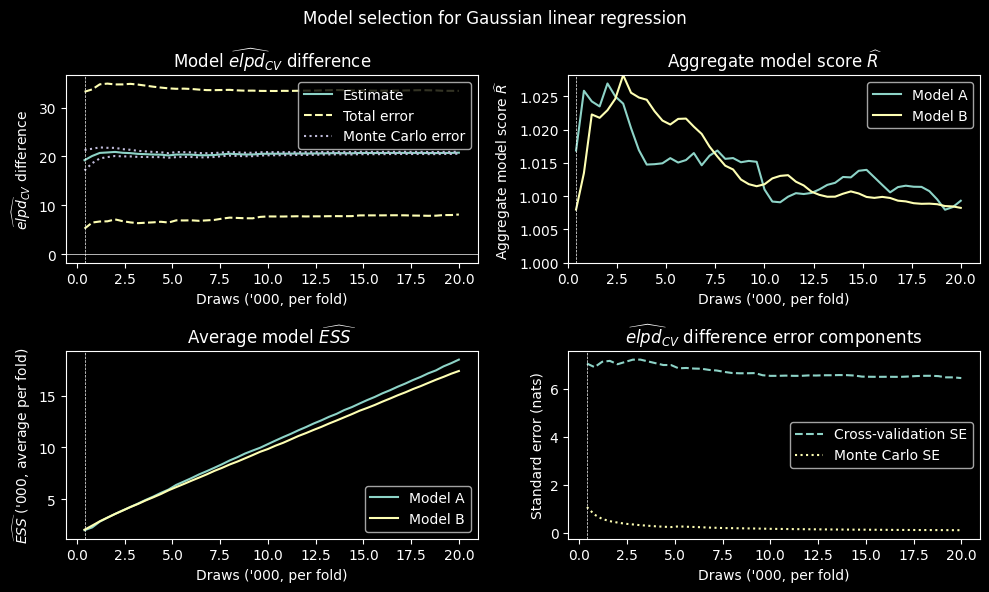

In [11]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

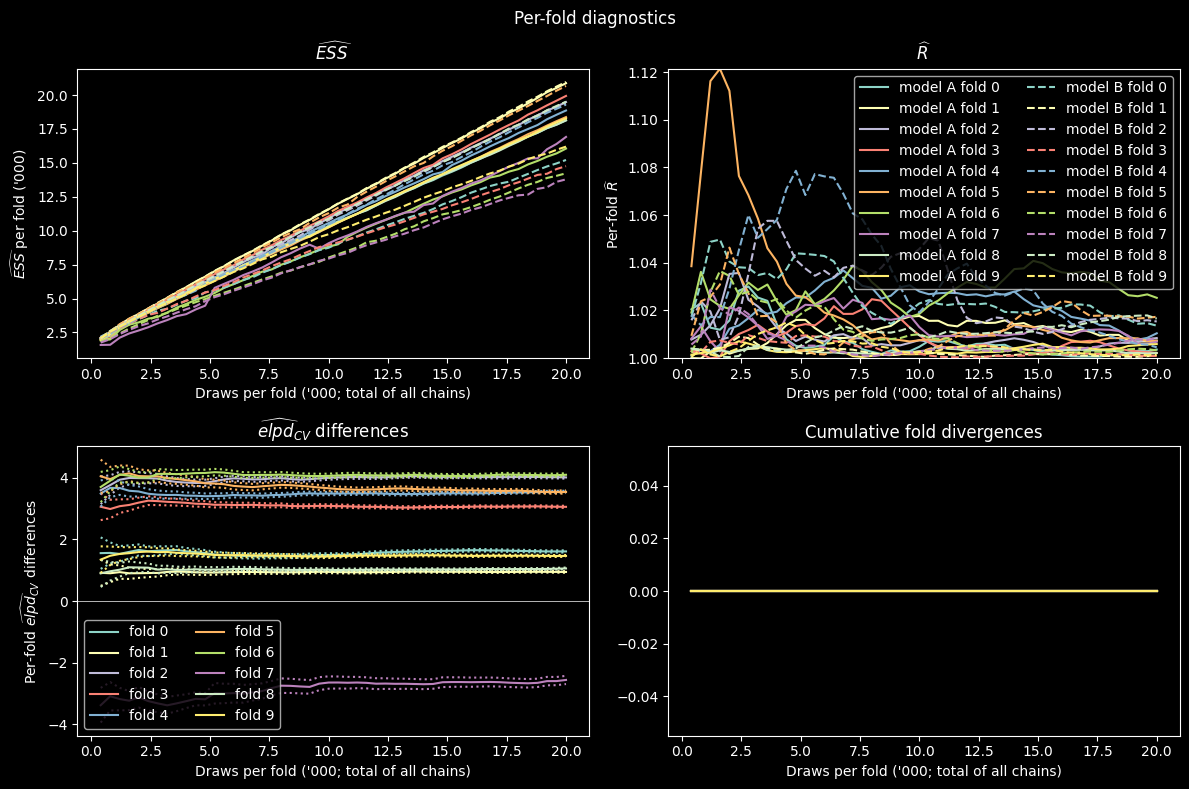

In [12]:
plot_fold_results(results, title='Per-fold diagnostics')

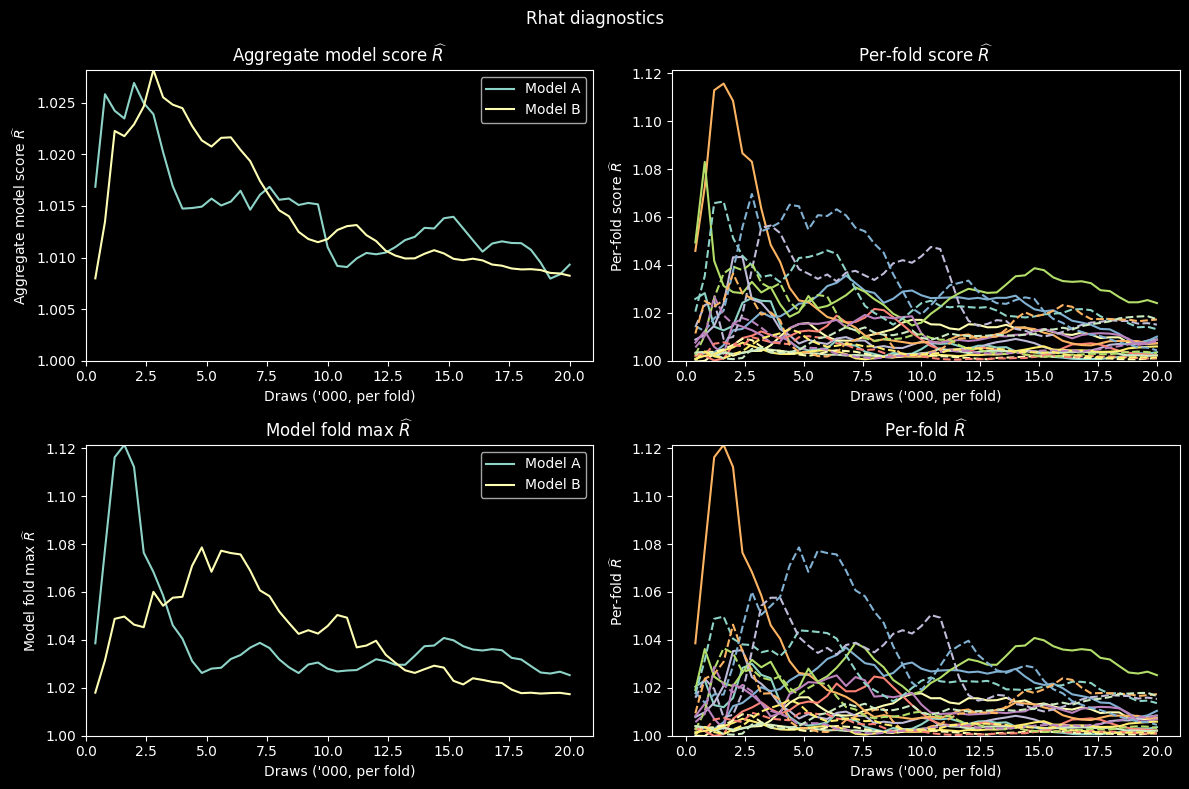

In [13]:
plot_rhats(results)